In [1]:
from matplotlib import pyplot as plt
from dataclasses import dataclass
from typing import Callable, Optional, TypeVar
import numpy as np
import itertools

# Random walk


In [44]:
class Solver:
    pass


@dataclass
class RndWalkSolver(Solver):
    dim: int
    mn: np.array
    mx: np.array
    stp: float
    atmps: int = 100

    def get_rnd_point(self):  # Apply rand to min max range
        return self.mn + (np.random.rand(self.dim) * (self.mx - self.mn))

    def get_rnd_step(self, pnt):
        end = None

        for i in range(1000):  # Prevent infinite loops
            if end is not None and (end < self.mx).all() and (end > self.mn).all():
                break

            end = pnt

            # Make a step in random direction in n dimensional space
            # step is a distance between 2 points, given by step = sqrt(x1**2 + x2**2 + x3**2 +...)
            # then step**2 is a sum of steps in each direction**2.
            # Due to implementation restricts first assume step is 1 then resize sum of squares to required step.
            d = np.sqrt(
                np.random.dirichlet(
                    # Assume step size is 1 -> 1**2 is sqrt(x1**2 + x2**2 + x3**2 +...)
                    np.ones(self.dim), size=1**2
                ) * self.stp**2  # Resize to required step size
            )[0]
            # Change direction randomly (otherwise function will only grow)
            d = np.where(
                np.random.choice(
                    a=[False, True],
                    size=(self.dim)
                ), -d, d
            )

            end = pnt + d
        else:  # Not feasible in N iterations
            raise RuntimeError('Not feasible')

        return end

    def solve(self, trg: Callable[[np.array], np.array], cmp: Callable[[float, float], bool], vis=False):
        ax = None
        if vis:
            ax = plt.subplot()

        bst = self.get_rnd_point()
        bst_f = trg(bst)

        lst = bst
        for i in range(self.atmps):
            tst = self.get_rnd_step(lst)
            tst_f = trg(tst)

            if cmp(bst_f, tst_f):
                bst, bst_f = tst, tst_f

            if ax is not None and self.dim == 2:
                ax.plot([
                    lst[0], tst[0],
                ], [
                    lst[1], tst[1]
                ], color='b', alpha=0.2)
                ax.scatter(tst[0], tst[1], s=tst_f, color='b', alpha=0.2)

            lst = tst

        if ax is not None and self.dim == 2:
            ax.scatter(bst[0], bst[1], s=bst_f, color='r', alpha=0.5)

        return bst, bst_f


(array([3.08869789, 3.07767634]), 31.67764322062992)

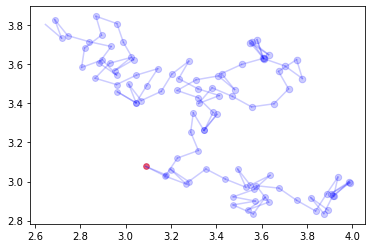

In [45]:
def target(x: np.array):
    return np.sum(x**2+4*x-6)


slv = RndWalkSolver(2, np.array([2, 2]), np.array([4.5, 4.5]), 0.1, 100)
slv.solve(target, lambda bp, tp: tp < bp, True)


# Neural network


In [46]:
tN = TypeVar('N', bound='N')


@dataclass
class N:
    w: np.array
    b: float

    thr: Optional[float] = None
    act_fn: Optional[Callable[[float], float]] = None
    act_fn_dir: Optional[Callable[[float], float]
                         ] = None  # derivation of act_fn

    # params update logic
    # TODO: keep space reference and use live parameters by index straight from space
    _partition_start_index: int = 0
    _partition_end_index: int = 0

    # Presented correction to apply (bp alg)
    _correction_w: np.array = None
    _correction_b: float = None

    # Hold last value of ip
    _i_p: Optional[float] = None
    # Hold activation last value
    _y: Optional[float] = None
    # Hold input values
    _x: Optional[np.array] = None

    # Internal potencial (save last calculated)
    def calc_ip(self, x) -> float:
        self._x = x
        self._i_p = np.dot(x, self.w) + self.b
        return self._i_p

    def setup_partition(self, start_index) -> tuple[int, np.array]:
        partition = [*self.w, self.b]
        if self.thr is not None:
            partition.append(self.thr)

        self._partition_start_index = start_index
        self._partition_end_index = start_index + len(partition)

        return self._partition_end_index, np.array(partition)

    def update_from_partition(self, partition: np.array):
        partition = partition[self._partition_start_index: self._partition_end_index]
        if self.thr is not None:
            *self.w, self.b, self.thr = partition
        else:
            *self.w, self.b = partition

    def setup_correction(self, d_w: np.array, d_b: float):
        self._correction_w = d_w
        self._correction_b = d_b

    def apply_correction(self):
        self.w = self.w + self._correction_w
        self.b = self.b + self._correction_b

    def apply(self, x: np.array) -> float:
        self._y = self.trigger_act_fn(x)
        return self._y

    def trigger_act_fn(self, x: np.array):
        raise NotImplemented()


class ThresholdN(N):
    def fn(self, ip):
        assert self.act_fn is not None
        return 1 if self.act_fn(ip) >= self.thr else 0

    def trigger_act_fn(self, x: np.array):
        ip = self.calc_ip(x)
        return self.fn(ip)


class PerceptronN(N):
    def fn(self, x: float):
        return -1 if x < -self.thr else 1 if x > self.thr else 0

    def trigger_act_fn(self, x: np.array):
        ip = self.calc_ip(x)
        return self.fn(ip)


In [64]:

class NN:
    class L:
        neurons: list[N]

        def __init__(self, neurons: list[N]):
            self.neurons = neurons

        def apply(self, x: np.array) -> np.array:
            return np.array([n.apply(x) for n in self.neurons])

        def setup_partition(self, start_index: int) -> tuple[int, np.array]:
            space = []
            for n in self.neurons:
                start_index, partition = n.setup_partition(start_index)
                space.extend(partition)
            return start_index, np.array(space)

        def update_from_partition(self, partition: np.array):
            for n in self.neurons:
                n.update_from_partition(partition)

    layers: list[L]

    def __init__(self, layers: list[L]):
        self.layers = layers

    def apply(self, x: np.array):
        for l in self.layers:
            x = l.apply(x)
        return x

    def setup_partition(self) -> np.array:
        space, start_index = [], 0
        for l in self.layers:
            start_index, partition = l.setup_partition(start_index)
            space.extend(partition)
        return np.array(space)

    def update_from_partition(self, space: np.array):
        for l in self.layers:
            l.update_from_partition(space)

    def back_propagation(self, y: np.array, a: float):
        out_l = self.layers[-1]

        # Calculate error out nn
        d_out_l = (y - np.array([n._y for n in out_l.neurons])) * \
            np.array([n.act_fn_dir(n._i_p) for n in out_l.neurons])

        for i, n in enumerate(out_l.neurons):
            d_w = a * d_out_l[i] * n._x
            d_b = a * d_out_l[i]
            n.setup_correction(d_w, d_b)

        prev_l = out_l
        for l in reversed(self.layers[:-1]):
            d_in_inn_l = 0
            for i, n in enumerate(l.neurons):
                for ii, prev_l_n in enumerate(prev_l.neurons):
                    d_in_inn_l += d_out_l[ii] * prev_l_n.w[i]
                d_inn_l = d_in_inn_l * n.act_fn_dir(n._i_p)

                d_w = a * d_inn_l * n._x
                d_b = a * d_inn_l

                n.setup_correction(d_w, d_b)

            prov_l = l
            d_out_l = d_inn_l  # ????

        for l in self.layers:
            for n in l.neurons:
                n.apply_correction()


In [4]:
data = [
    [np.array((0, 0)), 0],
    [np.array((0, 1)), 1],
    [np.array((1, 0)), 1],
    [np.array((1, 1)), 0],
]


def test(nn):
    for x, y in data:
        p_y = nn.apply(x)[0]
        print(f'{x} -> {p_y} ({y})')

In [60]:
n1 = ThresholdN(w=np.array([0, 0]), b=0, thr=0, act_fn=np.tanh)
n2 = ThresholdN(w=np.array([0, 0]), b=0, thr=0, act_fn=np.tanh)
n3 = ThresholdN(w=np.array([0, 0]), b=0, thr=0, act_fn=np.tanh)

l1 = NN.L([n1, n2])
l2 = NN.L([n3])

nn = NN([l1, l2])

start = nn.setup_partition()
mn, mx = start - 1, start + 1


def metrics(test):
    nn.update_from_partition(test)

    score = 0
    for x, y in data:
        if nn.apply(x)[0] == y:
            score += 1

    return score


# Init solver
slv = RndWalkSolver(len(start), mn, mx, 0.2, 30000)

# Solve
tweaks, score = slv.solve(metrics, lambda bp, tp: tp > bp, False)
nn.update_from_partition(tweaks)

test(nn)
print(f'best: {tweaks}, score: {score}')

[0 0] -> 0 (0)
[0 1] -> 1 (1)
[1 0] -> 1 (1)
[1 1] -> 0 (0)
best: [-0.96292085  0.3203843  -0.05741452 -0.72137046  0.80242842 -0.64379155
  0.26863498 -0.28467946 -0.46579092 -0.42330519 -0.1095741  -0.74723195], score: 4


In [65]:
def tanh_dir(value: float) -> float:
    # https://blogs.cuit.columbia.edu/zp2130/derivative_of_tanh_function/
    return 1 - np.tanh(value)**2


def get_n():
    return ThresholdN(
        w=np.random.rand(2),
        b=np.random.rand(),
        thr=np.random.rand(),
        act_fn=np.tanh,
        act_fn_dir=tanh_dir
    )


n1 = get_n()
n2 = get_n()
n3 = get_n()

l1 = NN.L([n1, n2])
l2 = NN.L([n3])

nn = NN([l1, l2])

a = 0.5
counter = 100000
for x, y in itertools.cycle(data):
    if not counter:
        break

    counter -= 1

    nn.apply(x)
    nn.back_propagation(np.array([y]), a)

test(nn)


[0 0] -> 0 (0)
[0 1] -> 1 (1)
[1 0] -> 0 (1)
[1 1] -> 0 (0)
